# Class 19: Hypothesis tests for proportions and means

Plan for today:
- Hypothesis tests for a single proportion


In [1]:
import YData

# YData.download.download_class_code(19)   # get class code    
# YData.download.download_class_code(19, TRUE) # get the code with the answers 

# YData.download.download_class_file('project_template.ipynb', 'homework')  # downloads the class project template 
# YData.download_homework(8)  # downloads the 7th homework 

YData.download_data("movies.csv")
YData.download_data("daily_bike_totals.csv")
YData.download_data("bta.csv")
YData.download_data("babies.csv")

In [2]:
## If you are using Google Colabs, you should install the YData packages and mount the your google drive by uncommenting and running the code below.

# !pip install https://github.com/emeyers/YData_package/tarball/master
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import statistics
import pandas as pd
import numpy as np
from urllib.request import urlopen

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Simulating coin flips

Below is the code we wrote for simulating the number of heads we would get from flipping a coin *n* times where the probability of getting a head on each flip is giving by the *prob* argument. We will use this function in our hypothesis testing for a single proportion. 


In [4]:
# Add an argument return_prop that when set to True will return the proporton of coin flips that were heads (rather than the number of heads)

def flip_coins(n, prob, return_prop = False):
    
    rand_nums = np.random.rand(n)
    num_heads = np.sum(rand_nums <= prob)
    
    if return_prop:
        return num_heads/n
    else:
        return num_heads
    

# Testing the function 
print(flip_coins(500, .5))
print(flip_coins(500, .5, True))


248
0.54


## 2. Hypothesis tests

In hypothesis testing, we start with a claim about a population parameter (e.g., µ = 4.2, or π = 0.25).

This claim implies we should get a certain distribution of statistics, called "The null distribution". 

If our observed statistic is highly unlikely to come from the null distribution, we reject the claim. 

We can break down the process of running a hypothesis test into 5 steps. 

1. State the null and alternative hypothesis
2. Calculate the observed statistic of interest
3. Create the null distribution 
4. Calculate the p-value 
5. Make a decision

Let's run through these steps now!


#### Step 1: State the null and alternative hypothesis

$H_0: \pi = 0.5$

$H_A: \pi < 0.5$


#### Step 2: Calculate the observed statistic of interest


In [5]:
# load the data

movies = pd.read_csv("movies.csv")

movies.head(3)

,year,imdb,title,test,clean_test,binary,budget,domgross,intgross,code,...,director,released,actors,genre,awards,runtime,type,poster,imdb_votes,error
0,2013,tt1711425,21 &amp; Over,notalk,notalk,FAIL,13000000,25682380.0,42195766.0,2013FAIL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012,tt1343727,Dredd 3D,ok-disagree,ok,PASS,45000000,13414714.0,40868994.0,2012PASS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,tt2024544,12 Years a Slave,notalk-disagree,notalk,FAIL,20000000,53107035.0,158607035.0,2013FAIL,...,Steve McQueen,08 Nov 2013,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...","Biography, Drama, History",Won 3 Oscars. Another 131 wins & 137 nominations.,134 min,movie,http://ia.media-imdb.com/images/M/MV5BMjExMTEz...,"143,446",NaN


In [6]:
# reduce data to a smaller number of columns: "title" and "binary"

movies_smaller = movies[["title", "binary"]]

In [7]:
# calculate the proportion of movies that pass the Bechdel test

booleans_passed = movies_smaller["binary"] == "PASS"

prop_passed = np.mean(booleans_passed)

prop_passed


np.float64(0.447603121516165)

#### Step 3: Create the null distribution 

We need to create a null distribution, which is the distribution of statistics we would expect to get if the null hypothesis is true. 

**Question**: about what percent of the movies would we expect to pass the Bechdel test if the null distribution was true? 

**Answer**: 50%

Let's create simulated data that is consistent with this!


In [8]:
# Let's generate one proportion consistent with the null hypothesis

# get the total number of movies in our dataset n
n = movies.shape[0]
print(n)

# proportion consistent with the null hypothesis
null_prop = .5


# one statistic consistent with null hypothesis
flip_coins(n,  null_prop, return_prop = True)



1794


np.float64(0.5)

In [9]:
# Let's generate a null distribution 

null_dist = []

for i in range(10000):
    simulated_null_prop = flip_coins(n,  null_prop, return_prop = True)
    null_dist.append(simulated_null_prop)


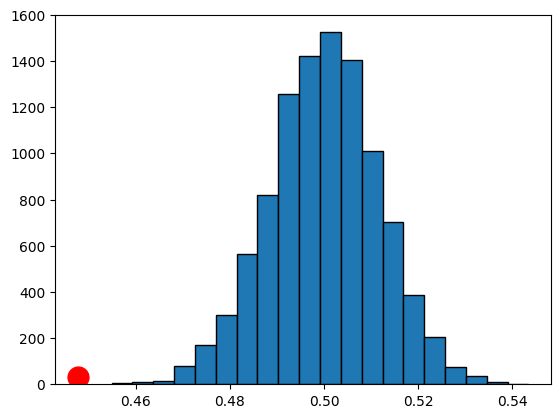

In [10]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 20) #, range = (.4, .6));
plt.plot(prop_passed, 30, '.', markersize = 30, color = "red");

#### Step 4: Calculate the p-value 

Calculate the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [11]:
# Calculate the p-value

# create a Boolean vector indicating whether each p-hat in the null distribution 
# was greater than the observed proportion that passed the Bechdel test
stats_more_extreme = np.array(null_dist) <= prop_passed

print(stats_more_extreme[0:5])

# calculate the p-value 
p_value = np.mean(stats_more_extreme)

p_value

[False False False False False]


np.float64(0.0)

#### Step 5: Make a decision

Since the p-value is very small (essentially zero) it is very unlikely that our statistic come from the null distribution. Thus we will reject the null hypothesis and conclude that less than 50% of movies pass the Bechdel test. 


## 3. Another example: Hypothesis test for a single proportion - sinister lawyers

10% of American popula on is left-handed. A study found that out of a random sample of 105 lawyers, 16 were left-handed. Use our 5 steps of hypothesis testing to assess whether the proportion of left-handed lawyers is greater than the proportion on found in the American population. 


### Step 1: State the null and alternative hypotheses

**In words** 

Null hypothesis: 10% of lawyers are left-handed.

Alternative hypothesis: More than 10% of lawyers are left-handed.


**In symbols**

$H_0$: $\pi = .10$

$H_A$: $\pi > .10$


### Step 2: Calculate the observed statistic

Calculate the observed statistic and save it to the name `obs_stat`. 

What symbol should we use to denote this observed statistic? 


In [12]:
obs_stat = 16/105

obs_stat

0.1523809523809524

### Step 3: Create the null distribution 

To create the null distribution let's use the code we wrote to simulate the proportion of heads we get from flipping a coin *n* times. 

As we discusswed above, the code `flip_coins(n, prob_heads, return_prop)` simulates flipping a coin *n* times with a probability of getting heads given by the argument `prob_heads` (make sure you understand how this code works!). 

Use this code to simulate one statistic $\hat{p}$ that is consistent with the null hypothesis below...

In [13]:

flip_coins(105, .1, return_prop = True)



np.float64(0.1523809523809524)

Now generate a null distribution, by using a for loop to create 10,000 statistics consistent with the null hypothesis. Store this null distribution in an object called `null_dist`. 

In [14]:
# Create the null distribution

null_dist = []

for i in range(10000):
    curr_null_stat = flip_coins(105, .1, return_prop = True)
    null_dist.append(curr_null_stat)



Let's also visualize the null distribution as a histogram. Set the `bins` argument to 100 to create 100 bins in this histogram. 

Does the observed statistic you calculated in step 2 seem like it is likely to come from this null distribution? 

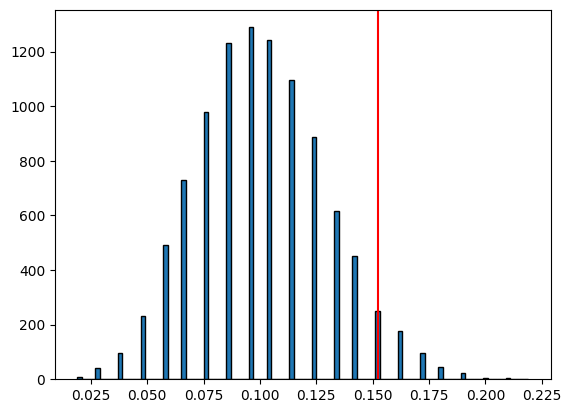

In [15]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# add a red vertical line at th evalue of the observed statistic

plt.axvline(obs_stat, color = "r");


### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [16]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

np.float64(0.0607)

### Step 5: Draw a conclusion

Is there convincing evidence to reject the null hypothesis? 

Do you believe lawyers are more sinister than the general American public? 


<br>
<center>
<img src="https://github.com/emeyers/YData/blob/main/ClassMaterial/images/lawyer.jpg?raw=true" alt="lawyer" style="width: 200px;"/>
</center>
<br>

## 4. Hypothesis test for two proportions

In hypothesis testing, we start with a claim about a population parameter (e.g., µ = 4.2, or π = 0.25).

This claim implies we should get a certain distribution of statistics, called "The null distribution". 

If our observed statistic is highly unlikely to come from the null distribution, we reject the claim. 

We can break down the process of running a hypothesis test into 5 steps. 

1. State the null and alternative hypothesis
2. Calculate the observed statistic of interest
3. Create the null distribution 
4. Calculate the p-value 
5. Make a decision

Let's run through these steps now by doing one more practice problem running a hypothesis test for a single proportion!


### Step 1: State the null and alternative hypotheses


$H_0$: $\pi_{treat} =  \pi_{control}$   or    $H_0$: $\pi_{treat} -  \pi_{control} = 0$ 

$H_A$: $\pi_{control} < \pi_{treat}$    or    $H_0$: $\pi_{treat} -  \pi_{control} < 0$ 



Where $\pi_{treat}$ and $\pi_{control}$ and the population proportions of people who experienced back pain relief after receiving the BTA or control respectively. 


### Step 2: Calculate the observed statistic

The code below loads the data from the study. We can use the difference in proportions  $\hat{p}_{treat} - \hat{p}_{control}$  as our observed statistic. 

Let's calculate the observe statistic and save it to the name `obs_stat`.


In [17]:
bta = pd.read_csv('bta.csv')
bta.sample(frac = 1)

,Group,Result
14,Control,0.0
7,Control,0.0
24,Treatment,1.0
16,Treatment,1.0
6,Control,0.0
27,Treatment,0.0
22,Treatment,1.0
0,Control,1.0
26,Treatment,0.0
11,Control,0.0


In [18]:
# create a DataFrame with the proportion of people in the treatment and control groups that have pain relief 

results_table = bta.groupby("Group").mean()

results_table

,Result
Group,
Control,0.125
Treatment,0.600


In [19]:
# calculate the difference
obs_stat_series = results_table.loc["Treatment"] - results_table.loc["Control"]

# extract the value from a series to 
obs_stat = obs_stat_series.iloc[0]

obs_stat

np.float64(0.475)

In [20]:
# let's write a function to make it easy to get statistic values

def get_prop_diff(bta_data):
    
    group_means = bta_data.groupby("Group").mean()
    
    the_difference = group_means.loc["Treatment"] - group_means.loc["Control"]
    
    return the_difference.iloc[0]


# Try the function out
get_prop_diff(bta)


np.float64(0.475)

### Step 3: Create the null distribution 

To create the null distribution, we need to create statistics consistent with the null hypothesis. 

In this example, if the null hypothesis was true, then there would be no difference between the treatment and control group. Thus, under the null hypothesis, we can shuffle the group labels and get equally valid statistics. 

Let's create one statistic consistent with the null distribution to understand the process. We can then repeat this 10,000 times to get a full null distribution. 

In [21]:
# shuffle the data 

shuff_bta = bta.copy()
shuff_bta['Group'] = np.random.permutation(bta["Group"])

shuff_bta.head()


,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Treatment,0.0
4,Treatment,0.0


In [22]:
# get one statistic consistent with the null distribution 

get_prop_diff(shuff_bta)

np.float64(-0.3)

In [23]:
%%time

# create a full null distribution 

null_dist = []

for i in range(10000):
    
    shuff_bta['Group'] = np.random.permutation(bta["Group"])
    
    shuff_stat = get_prop_diff(shuff_bta)
    
    null_dist.append(shuff_stat)


CPU times: user 3.91 s, sys: 3.28 ms, total: 3.91 s
Wall time: 3.94 s


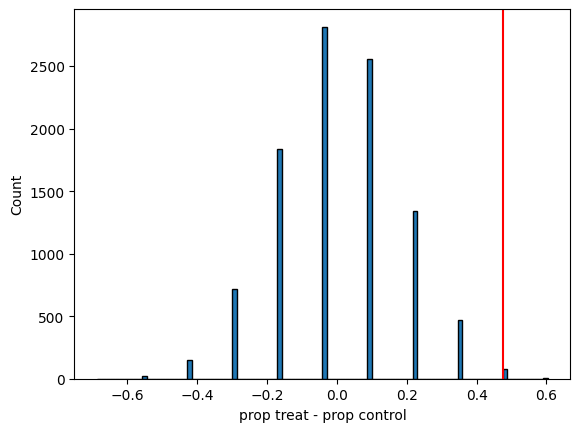

In [24]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("prop treat - prop control");
plt.ylabel("Count");

### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [25]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

np.float64(0.0088)

### Step 5: Draw a conclusion

Since the p-value is less than the typical significance level of 0.05, we can reject the null hypothesis. Because the participants were **randomly assigned to the treatment and control groups**, we canconclude that BTA does **cause** pain relief at a higher rate than the placebo. 

<br>
<center>
<img src="https://image.spreadshirtmedia.com/image-server/v1/compositions/T347A2PA4306PT17X24Y42D1035176833W20392H24471/views/1,width=550,height=550,appearanceId=2,backgroundColor=000000,noPt=true/ok-but-first-botox-fillers-botox-funny-botox-womens-t-shirt.jpg" alt="botox" style="width: 200px;"/>
</center>
<br>

## 5. Hypothesis test for two means: Smoking and baby weights

The Child Health and Development Studies investigate a range of topics. One study, in particular, considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area.

Let's examine this data to see if the average weight of babies of babies is different depending on whether the mother of the baby smokes. 


### Step 1: State the null and alternative hypotheses


$H_0$: $\mu_{non-smoke} =  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} = 0$ 

$H_A$: $\mu_{non-smoke} >  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} > 0$ 


Where $\mu_{non-smoke}$ and $\mu_{smoke}$ are the population means of babies born to mothers who did not smoke and who smoked.

### Step 2: Calculate the observed statistic

The code below loads the data from the study. The two relevant columns are:
- `bwt`: The birth weight of the baby in ounces
- `smokes`: whether the mother smokes (1) or does not smoke (0)

More information about the data is available at: https://www.openintro.org/data/index.php?data=babies

In [26]:
babies = pd.read_csv("babies.csv")

babies.head()

,case,bwt,gestation,parity,age,height,weight,smoke
0,1,120,284.0,0,27.0,62.0,100.0,0.0
1,2,113,282.0,0,33.0,64.0,135.0,0.0
2,3,128,279.0,0,28.0,64.0,115.0,1.0
3,4,123,NaN,0,36.0,69.0,190.0,0.0
4,5,108,282.0,0,23.0,67.0,125.0,1.0


To simplify the analysis, create a new DataFrame called `babies2` that only has the smoke and bwt columns. 

In [27]:
# create a DataFrame called babies2 that has only the smoke and bwt columns
babies2 = babies[["smoke", "bwt"]]
babies2.head(3)

,smoke,bwt
0,0.0,120
1,0.0,113
2,1.0,128


Let's have our observed statistic be the different of sample means  $\bar{x}_{non-smoke} - \bar{x}_{smoke}$.  

Please calculate this observe statistic and save it to the name `obs_stat`.


In [28]:
results_table = babies2.groupby("smoke").mean()
results_table

,bwt
smoke,
0.0,123.047170
1.0,114.109504


In [29]:

obs_stat_series = results_table.iloc[0] - results_table.iloc[1]

obs_stat = obs_stat_series.iloc[0]

obs_stat

np.float64(8.93766567908935)

To make the rest of the analysis easier, write a function `get_diff_baby_weights(babies_df)` that will take a DataFrame `babies_df` that has smoke and btw information will return the difference in the means of babies that have mothers who to not smoke and those who do smoke. 

Also, test the function to make sure it give the same observed statistic you calculated above

In [30]:
def get_diff_baby_weights(babies_df):
    
    results_table = babies_df.groupby("smoke").mean()
    obs_stat_series = results_table.iloc[0] - results_table.iloc[1]
    return obs_stat_series.iloc[0]


# get that the function works

get_diff_baby_weights(babies2)


np.float64(8.93766567908935)

### Step 3: Create the null distribution 

Now let's create a null distribution that has 10,000 statistics that are consistent with the null hypothesis. 

In this example, if the null hypothesis was true, then there would be no difference between the smoking mothers and the non-smoking mothers. Thus, under the null hypothesis, we can shuffle the group labels and get equally valid statistics. 

Let's create one statistic consistent with the null distribution to understand the process. We can then repeat this 10,000 times to get a full null distribution. 

In [31]:
# shuffle the data 

shuff_babies = babies2.copy()
shuff_babies['smoke'] = np.random.permutation(shuff_babies["smoke"])

get_diff_baby_weights(shuff_babies)


np.float64(-0.8948508609743584)

In [32]:
%%time

# create a full null distribution 

null_dist = []

for i in range(10000):  
    
    shuff_babies['smoke'] = np.random.permutation(shuff_babies["smoke"])
    
    shuff_stat = get_diff_baby_weights(shuff_babies)
    
    null_dist.append(shuff_stat)


CPU times: user 4.03 s, sys: 2.94 ms, total: 4.03 s
Wall time: 4.05 s


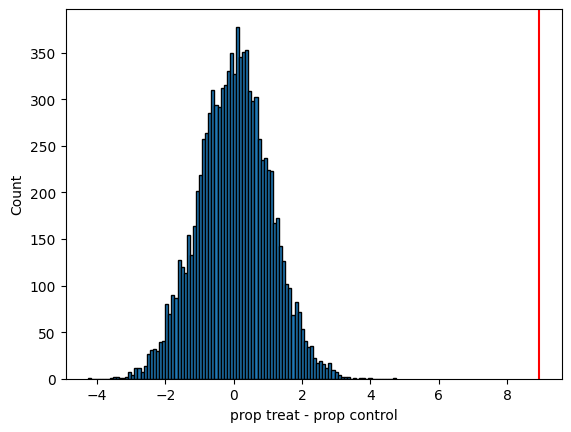

In [33]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("prop treat - prop control");
plt.ylabel("Count");

### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [34]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

np.float64(0.0)

### Step 5: Draw a conclusion

Since the p-value is less than the typical significance level of 0.05, we can reject the null hypothesis. This we conclude there is a difference between in the average weight of babies born to mothers who smoke compared to mothers who do not smoke. 

However, because this was an observational study, where mothers were **not** randomly assigned to treatment and control groups, we can conclude that smoking does causes babies to have less weight when they are born. In particular, it is possible there could be other "lurking/confounding" variables that cause both the mothers to smoke, and the babies to have less weight. 

<br>
<center>
<img src="https://i.ytimg.com/vi/x4c_wI6kQyE/maxresdefault.jpg" alt="smoking" style="width: 300px;"/>
</center>
<br>

In [35]:
%%capture

# You can run this code to covert this Jupyter notebook into a pdf
!quarto render class_19_answers.ipynb --cache-refresh --to pdf 